In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import f

In [ ]:
df = pd.read_excel('/content/Filtered_dataset.xlsx')

In [ ]:
print(df.shape)
print(df.head())

(38, 1501)
         0           1           2           3           4           5     \
0  123.415577  123.783202  123.919502  123.970103  123.988895  123.995791   
1    1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
2    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
3    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
4    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   

         6           7           8           9     ...   1491   1492   1493  \
0  123.998405  123.999395  123.999771  123.999913  ...  124.0  124.0  124.0   
1    1.000000    1.000000    1.000000    1.000000  ...    1.0    1.0    1.0   
2    0.000000    0.000000    0.000000    0.000000  ...    0.0    0.0    0.0   
3    0.000000    0.000000    0.000000    0.000000  ...    0.0    0.0    0.0   
4    0.000000    0.000000    0.000000    0.000000  ...    0.0    0.0    0.0   

    1494   1495   1496   1497   1498   1499   1500 

In [ ]:
X = df.to_numpy()

In [ ]:
print(X.shape)

(38, 1501)


In [ ]:
data = X.T
print(data.shape)

(1501, 38)


In [ ]:
print(data[:3,:3])

[[123.41557654   1.           0.        ]
 [123.78320248   1.           0.        ]
 [123.91950165   1.           0.        ]]


In [ ]:
def normalize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    sigma[sigma < 0.001] = 0.001
    return (X - mu) / sigma, mu, sigma

In [ ]:
class AutoencoderAEO(nn.Module):
  def __init__(self,input_dim,latent_dim=8):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_dim,16),
        nn.ReLU(),
        nn.Linear(16,latent_dim)
    )
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim,16),
        nn.ReLU(),
        nn.Linear(16,input_dim)
    )

  def forward(self,x):
    y = self.encoder(x)
    x_recon = self.decoder(y)
    return x_recon,y

In [ ]:
def aeo_loss(model,x,x_recon,y,Q,alpha=1.,beta=0.5,gamma=0.1):
    j1=alpha*torch.mean((x-x_recon)**2)
    y0=(y-y.mean(0,keepdim=True)).T
    j2=beta*torch.trace(y0.T@Q@y0)
    j3=gamma*sum(p.pow(2).sum() for p in model.parameters())
    return j1+j2+j3, j1, j2, j3

In [ ]:
def tune_q_collect_variances(data, q_values, epochs=300, lr=1e-3):
    """
    For each q in q_values:
      -  Q = diag([0.1*q,1*q,2*q,3*q,4*q])
      - We will train the autoencoder on clean dataset
      - Find the ideal value of q were ordering would take place
      - Record latent variances for plotting and visualising
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    X = torch.FloatTensor(data).to(device)
    input_dim = X.shape[1]
    latent_dim = 8
    latent_vars_matrix = []

    for q in q_values:
        # construct Q as specified
        weights = torch.FloatTensor([0.1*q, 1*q, 2*q, 3*q, 4*q,5*q,10*q,20*q]).to(device)
        Q = torch.diag(weights)

        # initialize model and optimizer
        model = AutoencoderAEO(input_dim,latent_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # train once on the data
        for epoches in range(epochs):
            x_recon, y = model(X)
            loss, _, _, _ = aeo_loss(model, X, x_recon, y, Q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if epoches%50==0:
             print(f"Epoch {epoches}, Loss: {loss.item()}")

        # collect variances of the latent code
        with torch.no_grad():
            y_out = model.encoder(X).cpu().numpy()
        vars_ = np.var(y_out, axis=0)
        latent_vars_matrix.append(vars_)

    return np.vstack(latent_vars_matrix)

In [ ]:
def plot_q_variances(latent_vars_matrix, q_values):
    """
    Plot variance of each latent dimension as a function of q.
    """
    plt.figure(figsize=(8,4))
    m = latent_vars_matrix.shape[1]
    for i in range(m):
        plt.plot(q_values, latent_vars_matrix[:, i], marker='o', label=f'Var(y{i+1})')
    plt.xlabel('q')
    plt.ylabel('Variance')
    plt.title('Ordered Latent Variances vs q')
    plt.xticks(q_values)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

Epoch 0, Loss: 17750.35546875
Epoch 50, Loss: 12689.697265625
Epoch 100, Loss: 2033.237060546875
Epoch 150, Loss: 330.0061340332031
Epoch 200, Loss: 67.58101654052734
Epoch 250, Loss: 32.76268768310547
Epoch 300, Loss: 24.63132667541504
Epoch 350, Loss: 15.970399856567383
Epoch 400, Loss: 10.081143379211426
Epoch 450, Loss: 7.419631004333496
Epoch 500, Loss: 5.950041770935059
Epoch 550, Loss: 4.894832134246826
Epoch 600, Loss: 3.4565625190734863
Epoch 650, Loss: 2.9207992553710938
Epoch 700, Loss: 2.6490540504455566
Epoch 750, Loss: 2.4818925857543945
Epoch 800, Loss: 2.3539514541625977
Epoch 850, Loss: 2.229429006576538
Epoch 900, Loss: 2.0318241119384766
Epoch 950, Loss: 1.9457101821899414
Epoch 1000, Loss: 1.8953226804733276
Epoch 1050, Loss: 1.8594788312911987
Epoch 1100, Loss: 1.8378806114196777
Epoch 1150, Loss: 1.8054574728012085
Epoch 1200, Loss: 1.7886611223220825
Epoch 1250, Loss: 1.763230323791504
Epoch 1300, Loss: 1.7450159788131714
Epoch 1350, Loss: 1.727804183959961
Epoch

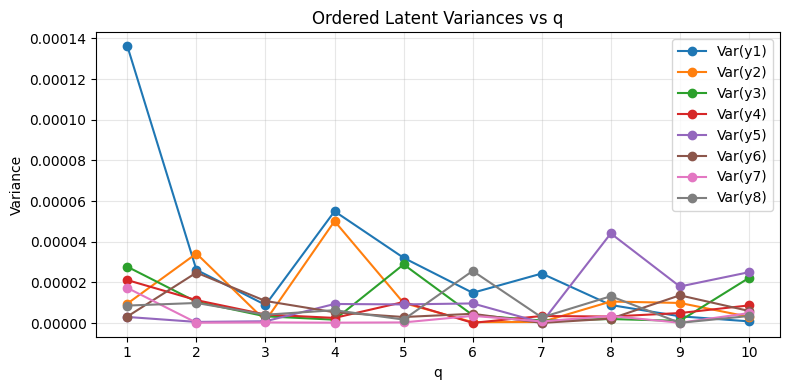

In [ ]:
q_values = list(range(1, 11))
latent_vars = tune_q_collect_variances(data, q_values,epochs=2000, lr=1e-3)
plot_q_variances(latent_vars, q_values)


In [ ]:
def aeo_monitoring_after_tuning(
    data, best_q,
    window_size=300,
    alpha=0.001,
    epochs=2000,
    lr=1e-3
):
    N, n = data.shape
    latent_dim = 8
    # Finding the T2 score for the initial window
    X0 = data[:window_size]
    Xn0, mu, sigma = normalize(X0)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    Xt0 = torch.FloatTensor(Xn0).to(device)

    # Q matrix from q
    weights = torch.FloatTensor([0,1*best_q,2*best_q,3*best_q,4*best_q,5*best_q,10*best_q,20*best_q]).to(device)
    Q = torch.diag(weights)

    model = AutoencoderAEO(n,latent_dim).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    for ep in range(epochs):
        x_r, y = model(Xt0)
        loss,_,_,_ = aeo_loss(model, Xt0, x_r, y, Q)
        opt.zero_grad()
        loss.backward()
        opt.step()
        if ep %50 ==0:
            print(f"Epoch {ep}, Loss: {loss.item()}")

    #  Extract latent and select principal components similar to the PCA
    with torch.no_grad():
        _, Y0t = model(Xt0)
    Y0 = Y0t.cpu().numpy()
    variances = Y0.var(axis=0)
    cum_var = variances.cumsum() / variances.sum()
    p = max(2, int((cum_var < 0.9).sum()) + 1)
    print(f"Number of significant dimensions in latent space are :- {p}")

    #  Mahalanobis metric with regularization
    Y0_centered = Y0[:, :p] - Y0[:, :p].mean(axis=0)
    covY = np.cov(Y0_centered.T) + 1e-6 * np.eye(p)
    Qy = np.linalg.inv(covY)

    m = window_size
    Cl = (p*(m-1)*(m+1)) / (m*(m-p)) * f.ppf(1-alpha, p, m-p)

    # Inference
    T2 = np.zeros(N)
    detected = []
    for k in range(window_size, N):
        xk = (data[k] - mu) / sigma
        with torch.no_grad():
            yk = model.encoder(torch.FloatTensor(xk).to(device)).cpu().numpy()
        yk_centered = yk[:p] - Y0[:, :p].mean(axis=0)
        T2[k] = yk_centered @ Qy @ yk_centered
        if T2[k] > Cl:
            detected.append(k)

    return T2, detected, Cl


Epoch 0, Loss: 343.71551513671875
Epoch 50, Loss: 9.653670310974121
Epoch 100, Loss: 2.5971994400024414
Epoch 150, Loss: 1.800396203994751
Epoch 200, Loss: 1.445326328277588
Epoch 250, Loss: 1.2395634651184082
Epoch 300, Loss: 1.1192331314086914
Epoch 350, Loss: 1.0464810132980347
Epoch 400, Loss: 0.990666389465332
Epoch 450, Loss: 0.9379391670227051
Epoch 500, Loss: 0.9046845436096191
Epoch 550, Loss: 0.8792606592178345
Epoch 600, Loss: 0.8561848402023315
Epoch 650, Loss: 0.8372871279716492
Epoch 700, Loss: 0.821466326713562
Epoch 750, Loss: 0.8083035945892334
Epoch 800, Loss: 0.7962212562561035
Epoch 850, Loss: 0.7850773930549622
Epoch 900, Loss: 0.7746976017951965
Epoch 950, Loss: 0.765023946762085
Epoch 1000, Loss: 0.7557242512702942
Epoch 1050, Loss: 0.7467344999313354
Epoch 1100, Loss: 0.7384288311004639
Epoch 1150, Loss: 0.7305641770362854
Epoch 1200, Loss: 0.7231637239456177
Epoch 1250, Loss: 0.7160296440124512
Epoch 1300, Loss: 0.7093021273612976
Epoch 1350, Loss: 0.7028433084

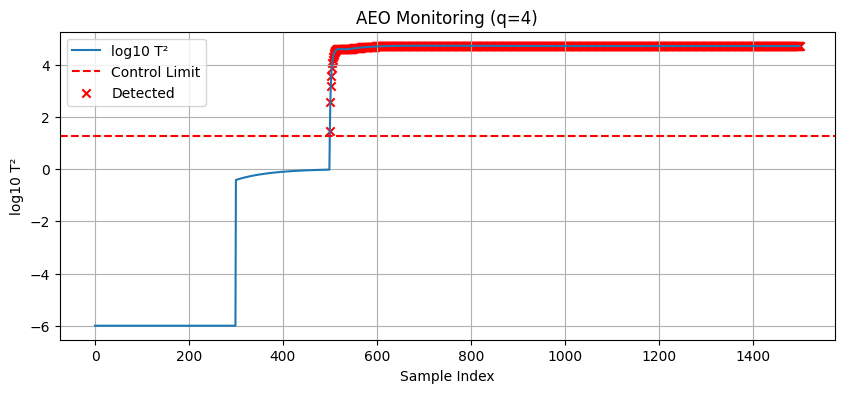

In [ ]:
best_q = 4
T2_scores,detected,control_limit = aeo_monitoring_after_tuning(data,best_q,window_size=300,alpha=0.01,epochs=2000,lr=1e-3)
print("Detected by AEO at   :", detected)
print(len(detected))

# Plot
plt.figure(figsize=(10,4))
plt.plot(np.log10(T2_scores + 1e-6), label='log10 T²')
plt.axhline(np.log10(control_limit), color='r', linestyle='--', label='Control Limit')
plt.scatter(detected, np.log10(T2_scores[detected] + 1e-6), c='r', marker='x', label='Detected')
plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title(f'AEO Monitoring (q={best_q})')
plt.legend(); plt.grid(True); plt.show()


## PCA Implementation


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
from numpy.linalg import eig, inv

In [ ]:
def normalize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    sigma[sigma < 0.001] = 0.001
    xn = (X - mu) / sigma
    return  mu, sigma,xn

In [ ]:
def train_pca(Xn, Vpc):
    C = np.cov(Xn, rowvar=False)
    vals, vecs = eig(C)
    idx = np.argsort(vals)[::-1]
    vals, vecs = vals[idx], vecs[:, idx]
    cum = np.cumsum(vals) / vals.sum() * 100
    Np = np.searchsorted(cum, Vpc) + 1
    Pp = vecs[:, :Np]
    Y = Xn.dot(Pp)
    return Np, Pp, vals[:Np], Y

In [ ]:
def compute_control_limit(Np, Nw, alpha=0.01):
    """
    Control limit Cl based on F-distribution:
      Cl = (Np*(Nw-1)*(Nw+1)) / (Nw*(Nw-Np)) * F(1-alpha; Np, Nw-Np)
    """
    Fcrit = f.ppf(1-alpha, Np, Nw-Np)
    Cl = (Np*(Nw-1)*(Nw+1)) / (Nw*(Nw-Np)) * Fcrit
    return Cl

/tmp/ipython-input-17-484643858.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  t2       = float(yk_cent @ invCy @ yk_cent)
/tmp/ipython-input-17-484643858.py:45: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(Ts2_all + 1e-6), label='log10 T²')


Detected anomalies at indices: [505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698

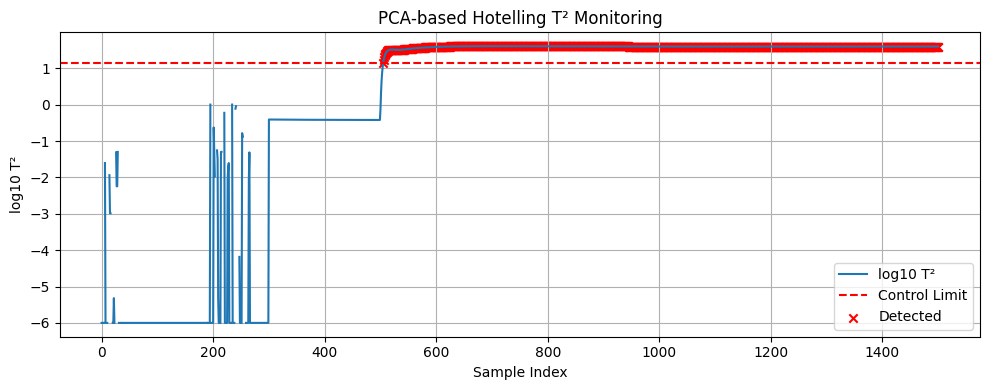

In [ ]:

window_size = 300    # initial PCA training window
Vpc         = 90     # percent variance to retain
alpha       = 0.01   # significance level

N, D = data.shape

# Train PCA on first window
X1     = data[:window_size, :]
mu, sigma, X1n = normalize(X1)
Np, Pp, eigs, Y1 = train_pca(X1n, Vpc)

# Compute control limit
Cl = compute_control_limit(Np, window_size, alpha)

#  Precompute for T²
meanY1 = Y1.mean(axis=0)            # shape (Np,)
Cy     = np.cov(Y1, rowvar=False)  # shape (Np, Np)
invCy  = inv(Cy)

#  T² for first window (centered)
Ts2_all = np.empty(N)
detected = []
# for k in range(window_size):
#     yk_centered = Y1[k] - meanY1
#     t2 = float(yk_centered @ invCy @ yk_centered)
#     Ts2_all[k] = t2
#     if t2 >= Cl:
#         detected.append(k)

# Inference on remaining samples
for k in range(window_size, N):
    x_norm = (data[k] - mu) / sigma
    yk      = x_norm.dot(Pp)
    yk_cent = yk - meanY1
    t2       = float(yk_cent @ invCy @ yk_cent)
    Ts2_all[k] = t2
    if t2 >= Cl:
        detected.append(k)

print("Detected anomalies at indices:", detected)
print("Total detected:", len(detected))

# Plotting the result
plt.figure(figsize=(10,4))
plt.plot(np.log10(Ts2_all + 1e-6), label='log10 T²')
plt.axhline(np.log10(Cl), color='r', linestyle='--', label='Control Limit')
plt.scatter(detected,
            np.log10(Ts2_all[detected] + 1e-6),
            c='r', marker='x', label='Detected')
plt.xlabel('Sample Index')
plt.ylabel('log10 T²')
plt.title('PCA‑based Hotelling T² Monitoring')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
